# Pet Detection

## Introduction

In this project, I am using cascade classifiers to detect pets in images. A cascade classifier is a machine learning algorithm that is trained to identify objects in images based on features such as texture, shape, and color.

My strategy for detecting pets in images is to first train a cascade classifier using a large dataset of positive and negative samples. The positive samples are images that contain pets, and the negative samples are images that do not contain pets.

To train the classifier, I will use the "traincascade" utility provided by OpenCV. This utility uses a supervised learning approach, where the classifier is trained on a labeled dataset of positive and negative samples. The classifier learns to distinguish between the two classes by analyzing the features of the samples and identifying patterns that are characteristic of pets.

Once the classifier is trained, I will use it to detect pets in new images. To do this, I will use the "detectMultiScale" function provided by OpenCV, which applies the classifier to a given image and returns a list of bounding boxes around any detected objects.

There are several reasons why this strategy is good for detecting pets in images. First, cascade classifiers are fast and efficient, making them suitable for real-time applications. Second, cascade classifiers are robust and able to handle a wide range of variations in the appearance of the objects being detected, such as different scales, orientations, and lighting conditions. Third, cascade classifiers are flexible and can be trained to detect a variety of different objects, making them a versatile tool for object detection.

In summary, my strategy for detecting pets in images using cascade classifiers is to first train a classifier using a large dataset of positive and negative samples, and then use the classifier to detect pets in new images. This approach is fast, efficient, robust, and flexible, making it a good choice for detecting pets in images.

### Resources

The resources used to understand object detection in opencv:
* [Haar Cascades, Explained](https://medium.com/analytics-vidhya/haar-cascades-explained-38210e57970d)
* [OpenCV Cascade classifier tutorial](https://docs.opencv.org/4.x/db/d28/tutorial_cascade_classifier.html)
* [OpenCV Tutorial Traincascade](https://docs.opencv.org/4.x/dc/d88/tutorial_traincascade.html)
* [Training OpenCV Classifier](https://learnopencv.com/install-opencv-docker-image-ubuntu-macos-windows)
* [OpenCV Training Example](https://www.youtube.com/watch?v=XrCAvs9AePM)
* [YoloV5](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)

### Building the dataset

The dataset used for opencv object detection will contain 2 types of images:
* Positive images: Images containing our favourite pet, with the location of the pet inside the images
* Negative Images: Images that can contain anything besides what we are trying to detect.

The negative images should be easy to collect, however for the positive images, we need to manually annotate the images, by specifying the location of the pets in our image. To accomplish this, we will use the [jupyter-bbox-widget](https://github.com/gereleth/jupyter-bbox-widget).

The annotation process is as follows:
1. Place all the positive and negative images in the ```img``` folder.
2. Iterate all the images in the folder.
3. For every image, once the user submits the image, if there are no annotations on the picture, we will consider it as a negative images, otherwise, as a positive image.

In [1]:
from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets
import os
import random
import cv2
from matplotlib import pyplot as plt
import shutil
import random

In [3]:
MY_FAVORITE_PET = "Fox"
IMAGE_PATH = 'img'

files = os.listdir(IMAGE_PATH)
random.shuffle(files)
annotations = {}

In [4]:
w_progress = widgets.IntProgress(value=0, max=len(files), description='Progress')
w_bbox = BBoxWidget(
    image = os.path.join(IMAGE_PATH,files[0]),
    classes=[MY_FAVORITE_PET]
)
w_container = widgets.VBox([
    w_progress,
    w_bbox,
])

In [5]:
# when Skip button is pressed we move on to the next file
@w_bbox.on_skip
def skip():
    w_progress.value += 1
    w_progress.value = w_progress.value % len(files)
    # open new image in the widget
    w_bbox.image = os.path.join(IMAGE_PATH,files[w_progress.value])
    # here we assign an empty list to bboxes but 
    # we could also run a detection model on the file
    # and use its output for creating inital bboxes
    w_bbox.bboxes = [] 

# when Submit button is pressed we save current annotations
# and then move on to the next file
@w_bbox.on_submit
def submit():
    image_file = files[w_progress.value]
    # save annotations for current image
    annotations[image_file] = w_bbox.bboxes
    # move on to the next file
    skip()

In [6]:
w_container

After iterating all the images, we will store the annotations to the disk, according to the requirements in the opencv [docs](https://docs.opencv.org/4.x/dc/d88/tutorial_traincascade.html)

In [8]:
def persist_annotations():
    """
    Write the annotations to the files.
    """
    with open('bg.txt', 'w') as negative_file, open('info.dat', 'w') as positive_file:
        for key, value in annotations.items():
            if len(value) == 0:
                negative_file.write(f'img/{key}\n')
            else:
                positive_file.write(f'img/{key}  {len(value)}')
                for annotation in value:
                    x = annotation['x']
                    y = annotation['y']
                    width = annotation['width']
                    height = annotation['height']
                    positive_file.write(f'  {x} {y} {width} {height} ')
                positive_file.write('\n')
                    
#persist_annotations()

### Modelization

A cascade classifier is a machine learning algorithm that is trained to identify objects in images based on features such as texture, shape, and color. It works by analyzing the features of an image and identifying patterns that are characteristic of the object being detected.

The cascade classifier is trained using a supervised learning approach, where the classifier is fed a labeled dataset of positive and negative samples. The positive samples are images that contain the object being detected, and the negative samples are images that do not contain the object. The classifier learns to distinguish between the two classes by analyzing the features of the samples and identifying patterns that are characteristic of the object.

I think that cascade classifiers are interesting for this dataset because they are fast and efficient, making them suitable for real-time applications. They are also robust and able to handle a wide range of variations in the appearance of the objects being detected, such as different scales, orientations, and lighting conditions. Finally, cascade classifiers are flexible and can be trained to detect a variety of different objects, making them a versatile tool for object detection.

#### Training
To build the final dataset, and train a classifier, we will use opencv_createsamples to create a vec file, and opencv_traincascade to train the classifier.
Since opencv version 4 no longer supports training cascade classifiers, I'll use the version 3.4.4.
I found this [docker image](https://learnopencv.com/install-opencv-docker-image-ubuntu-macos-windows) that comes preinstalled with opencv 3.4.4

To pull and run the image:
```
docker pull spmallick/opencv-docker:opencv
docker run -v C:\Users\elies\cv\pet_detection\imgs:/imgs -v /tmp/.X11-unix:/tmp/.X11-unix -v C:\Users\elies\cv\pet_detection\data:/data -e DISPLAY=$DISPLAY -p 5000:5000 -p 8888:8888 -it spmallick/opencv-docker:opencv /bin/bash
```

Once inside the image, make sure to place the generated annotations and pictures under the imgs volume, and run the following commands:
```
opencv_createsamples -info imgs/info.dat -vec out.vec -num 93 -bg bg.txt -w 50 -h 50
opencv_traincascade -data data -vec out.vec -bg /imgs/bg.txt -numPos 90 -numNeg 45 -numStages 20 -w 50 -h 50 -featureType HAAR
```

Once the training is finished, copy the generated cascade.xml file and place it in the same directory as the notebook

#### Metrics
The trainng metrics I received for the last stage are:
```
===== TRAINING 19-stage =====
<BEGIN
POS count : consumed   90 : 90
NEG count : acceptanceRatio    45 : 0.00487593
Precalculation time: 6
+----+---------+---------+
|  N |    HR   |    FA   |
+----+---------+---------+
|   1|        1|        1|
+----+---------+---------+
|   2|        1| 0.577778|
+----+---------+---------+
|   3|        1| 0.577778|
+----+---------+---------+
|   4|        1|      0.2|
+----+---------+---------+
END>
Training until now has taken 0 days 0 hours 8 minutes 15 seconds.
```
Where 
* HR: Hit Rate (% of positive samples that are classified correctly as such)
* FA: False Alarm (% of negative samples incorrectly classified as positive)

From the results we got, we can see that Hit Rate is 1, i.e. all positive samples are always correctly classified, and the False Alarm is 0.2 (1 out of 5 negative samples are misclassified)

#### Using the classifier

In [9]:
def find_pet(images, scale_factor=1.4, minNeighbors=6, minSize=(50, 50)):
    plt.rcParams["figure.figsize"] = (20,5)
    for index, image_path in enumerate(images):
        # Opening image
        img = cv2.imread(image_path)

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        stop_data = cv2.CascadeClassifier('cascade.xml')

        found = stop_data.detectMultiScale(img_gray, scaleFactor=scale_factor, 
                                         minNeighbors=minNeighbors, 
                                         minSize=minSize)

        for (x, y, width, height) in found:

            # We draw a green rectangle around
            # every recognized sign
            cv2.rectangle(img_rgb, (x, y), 
                          (x + height, y + width), 
                          (0, 255, 0), 2)

        # Creates the environment of 
        # the picture and shows it
        plt.subplot(1, len(images), index+1)
        plt.imshow(img_rgb)
    plt.show()

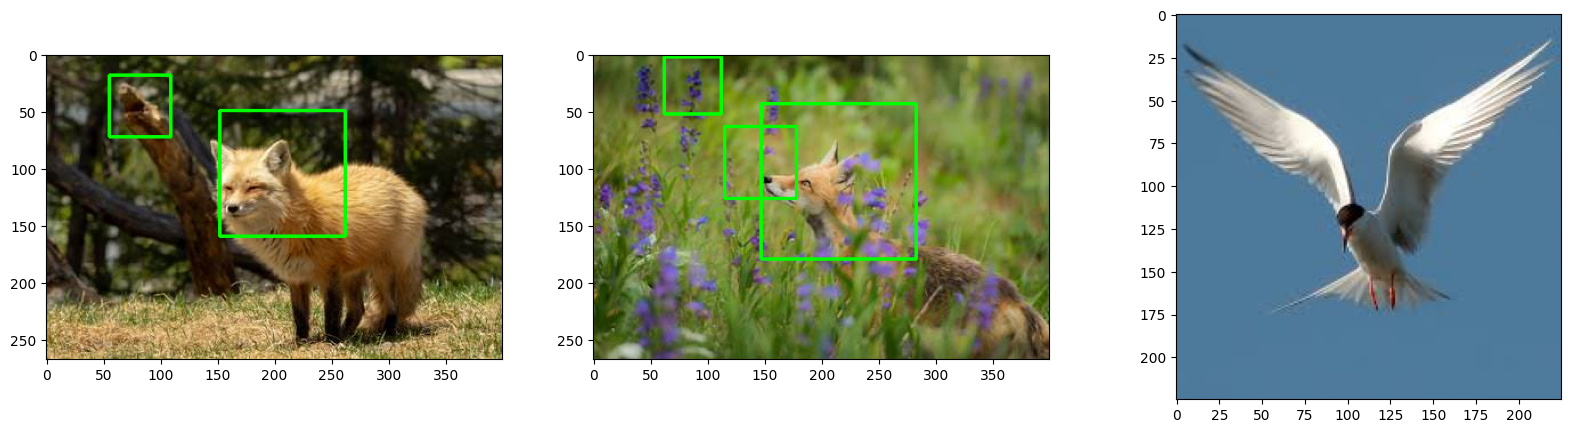

In [26]:
find_pet(["img/fox_5.jpg", "img/fox_1.jpg", "img/bird_0.jpg"], scale_factor=1.3, minNeighbors=6)

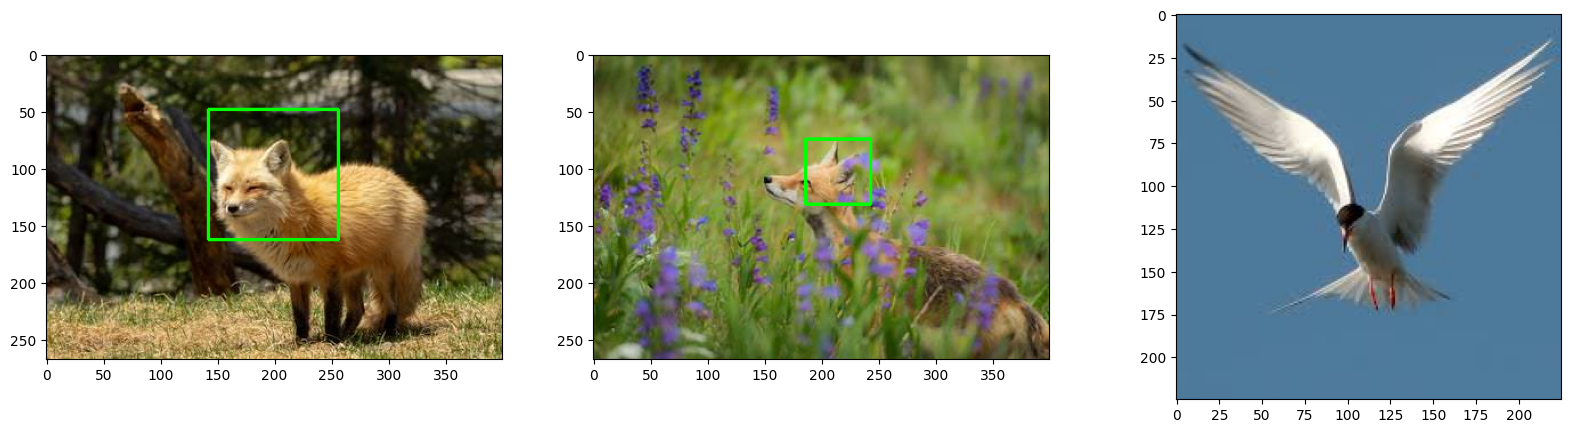

In [34]:
find_pet(["img/fox_5.jpg", "img/fox_1.jpg", "img/bird_0.jpg"], scale_factor=1.31, minNeighbors=10)

As we can see, our classifier is able to detect the fox faces in the images, however we should finetune the detectMultiScale method to get more or less accurate results.

### YOLO: You only look once

In [68]:
!git clone https://github.com/ultralytics/yolov5  # clone
!cd yolov5
!python3 -m pip install -r requirements.txt  # install

fatal: destination path 'yolov5' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable


### Create dataset.yaml

In [95]:
with open("yolov5/dataset.yaml", "w") as f:
    f.write("path: custom_data  # dataset root dir\n")
    f.write("train: train  # train images (relative to 'path')\n")
    f.write("val: val  # val images (relative to 'path')\n")
    f.write("test: test # test images (optional)\n")
    f.write("\n")
    f.write("\n")
    f.write("names:\n")
    f.write(f"  0: {MY_FAVORITE_PET}\n")

### Create labels

In [127]:
!mkdir -p yolov5/custom_data/train/images
!mkdir -p yolov5/custom_data/train/labels
!mkdir -p yolov5/custom_data/test/images
!mkdir -p yolov5/custom_data/test/labels
!mkdir -p yolov5/custom_data/val/images
!mkdir -p yolov5/custom_data/val/labels

In [128]:
with open('info.dat', 'r') as f:
    for line in f.readlines():
        image, _, x, y, width, height = line.split()
        rand = random.random()
        dir = 'train'
        shutil.copy2(image, f'yolov5/custom_data/{dir}/images/{image.split("/")[1]}')
        with open(f'yolov5/custom_data/{dir}/labels/{image.split("/")[1].split(".")[0]}.txt', "w") as lf:
            im = cv2.imread(image)
            lf.write(f'0 {(int(x) + int(width)/2) / im.shape[1]} {(int(y) + int(height)/2) / im.shape[0]} {int(width)/im.shape[1]} {int(height)/im.shape[0]}')

### Training

In [ ]:
!python3 yolov5/train.py --img 320 --batch 16 --epochs 20 --data yolov5/dataset.yaml --weights yolov5s.pt

After training the model, we take the output weights, load them using `torch.hub.load` function, and try to do inference on the test images.

In [2]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', path='./yolov5/runs/train/exp9/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/elie/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-1-3 Python-3.9.2 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce MX250, 2048MiB)

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


In [14]:
%matplotlib inline

def yolo5(image_path = 'img/fox_1.jpg'):
    found = model(image_path).pandas().xyxy[0]

    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for row in found.iterrows():
        cv2.rectangle(img_rgb, 
                      (int(row[1]['xmin']), int(row[1]['ymin'])), 
                      (int(row[1]['xmax']), int(row[1]['ymax'])), 
                      (0, 255, 0), 2)

    plt.imshow(img_rgb)
    plt.show()
    return found

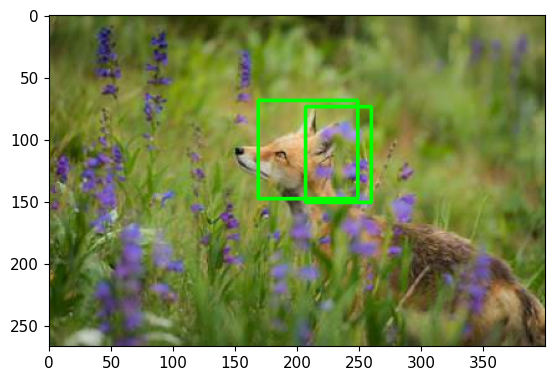

,xmin,ymin,xmax,ymax,confidence,class,name
0,206.248611,74.389679,259.676270,151.031525,0.341201,0,Fox
1,168.879211,69.657013,248.274872,148.838318,0.304050,0,Fox


In [15]:
yolo5()

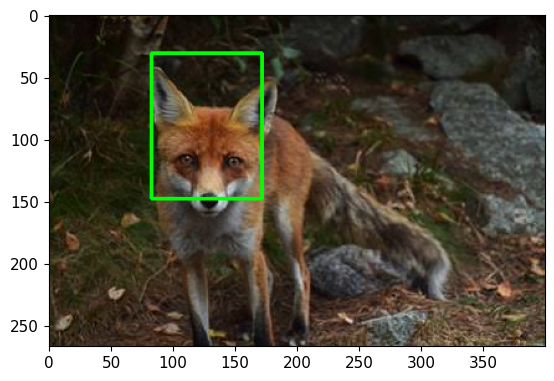

,xmin,ymin,xmax,ymax,confidence,class,name
0,82.506958,31.509752,171.163254,148.751144,0.259942,0,Fox


In [16]:
yolo5('img/fox_15.jpg')

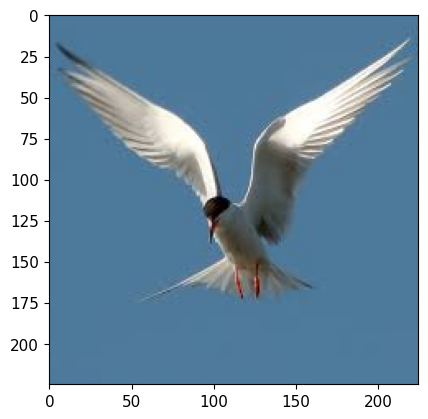

,xmin,ymin,xmax,ymax,confidence,class,name


In [17]:
yolo5('img/bird_0.jpg')

## Conclusion

In this project, we compared OpenCV cascade classifiers and YOLOv5 for the task of pet detection in images. We found that both methods were effective at detecting pets in the images, but YOLOv5 was generally faster and more accurate than the cascade classifiers.

One of the main advantages of YOLOv5 is its ability to process images in real-time, thanks to its efficient architecture and use of a single CNN for object detection. In contrast, cascade classifiers are typically slower and require multiple stages of processing to detect objects in images.

Overall, we found that YOLOv5 was a better choice for pet detection in images, due to its speed, accuracy, and ability to detect multiple objects. However, cascade classifiers may still be a useful tool in certain situations, such as when real-time performance is not required or when the object of interest is very small in the image.

In conclusion, YOLOv5 is a powerful and effective tool for pet detection in images, and is generally superior to cascade classifiers for this task. However, the choice of method will depend on the specific requirements and resources of the project.